# Sentiment and Topic Analysis of Trump's 2024 Campaign Speeches

---
In this project we aim to analyze the speeches delivered by [Donald Trump during his 2024 campaign](https://www.kaggle.com/datasets/perceptron90/donald-trump-2024-transcripts) across various states. The analysis focuses on sentiment detection using topic modelling techniques, highlighting sentiment trends over the time. The speeches are categorized into key campaign topics, including Gun Laws, Climate, Crime, Healthcare, Taxes, Ukraine Aid, Abortion, Immigration, and Economy.

## Teammates

- Porimol Chandro
- Thi Hoang Nhu Ho

## Table of Contents:
1. Project Objectives
1. Dataset Collection
1. Data Preprocessing
1. Exploratory Data Analysis (EDA)
1. Topic Modelling
1. Sentiment Analysis Based on BERT
1. Conclusion

---

## Project Objectives

- Use topic modelling to predict sentiment
- Analyze how sentiment emerged, evolved, or declined over time!


## Dataset Collection

- **Data Source:** In this sentiment analysis project we used election campaign speech delivered by Donald Trump.
- **Download Link:** [Donald Trump 2024 Transcripts](https://www.kaggle.com/datasets/perceptron90/donald-trump-2024-transcripts)

In [2]:
# Uncomments the following code to install the necessary packages

# !pip install --upgrade pip
# !pip install nltk
# !pip install skimpy
# !pip install wordcloud
# !pip install pandas numpy matplotlib seaborn scikit-learn vaderSentiment textblob transformers torch
# !pip install transformers['torch']
# !pip install 'accelerate>=0.26.0'

In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import re
import json
import time
import networkx as nx
import contractions
import nltk

# download NLTK resources
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

from ipysigma import Sigma
from itertools import combinations
from collections import Counter

from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from wordcloud import WordCloud, STOPWORDS

from transformers import pipeline
from transformers import BertTokenizer
from transformers import BertModel
from transformers import BertForSequenceClassification

from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from skimpy import skim

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)

[nltk_data] Downloading package punkt to /Users/chandp20/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/chandp20/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chandp20/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chandp20/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/chandp20/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/chandp20/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/chandp20/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Data Preprocessing

In [5]:
def extract_speech_date(file_name):
    date_match = re.search(r"(\d{8})", file_name)
    speech_date = date_match.group(1) if date_match else "Unknown"
    speech_date = pd.to_datetime(speech_date, format="%Y%m%d", errors="coerce").strftime("%Y-%m-%d")
    return speech_date


def extract_speech_location(file_name):
    location_match = re.search(r"in-([a-z\-]+)(?:\.|_|\-)", file_name)
    location_match1 = re.search(r"at-([a-z\-]+)(?:\.|_|\-)", file_name)
    if location_match:
        location = location_match.group(1).replace("-", " ").title() 
    elif location_match1: 
        location = location_match1.group(1).replace("-", " ").title()
    else:
        location = "Unknown"
    
    location = location.replace('Transcript', '') if 'Transcript' in location else location
    location = location.replace('Rally', '') if 'Rally' in location else location
    location = location.strip()
    return location


def extract_speaker_name(file_name):
    speaker = "Donald Trump" if "trump" in file_name.lower() or "donald-trump" in file_name.lower() else "Unknown"

    if "vance-and-trump" in file_name.lower():
        speaker = "Donald Trump and J.D. Vance"
    return speaker


def extract_title(file_name):
    title_match = re.search(r"(rally|town-hall|speech|address|interview)", file_name.lower())
    title = title_match.group(1).replace("-", " ").title() if title_match else "Unknown"
    return title


def get_speech_contents(file_path):
    try:
        with open(file_path, "r", encoding="utf-8") as file:
            contents = file.read()
    except FileNotFoundError:
        contents = "File not found"
    except Exception as e:
        contents = f"Error reading file: {e}"
    return contents

In [6]:
# function to extract information
def read_dataset(data_path):
    speache_cotents = []
    for file_name in os.listdir(data_path):
        if file_name.endswith('.txt'):
            file_path = os.path.join(data_path, file_name)
            
            # remove some words from the filename
            for word in ['speak', 'speaks', 'holds', 'deliver', 'former', 'takes', 'delivers']:
                file_name = file_name.replace(word, "")
            
            # Extract date
            date = extract_speech_date(file_name)
            # Extract location
            location = extract_speech_location(file_name)
            # Extract speaker
            speaker = extract_speaker_name(file_name)
            # extract title
            title = extract_title(file_name)
            # extract speech content
            speech = get_speech_contents(file_path)
            
            speache_cotents.append({
                "date": date,
                "location": location,
                # "deliverer": speaker,
                # "title": title,
                "speech": speech,
                "file_path": file_path
            })
    return speache_cotents


# directory containing .txt files
speache_cotents = read_dataset('data/text')
df = pd.DataFrame(speache_cotents).sort_values(by="date").reset_index(drop=True)
df.to_csv("data/speech_data.csv", index=False)


In [7]:
df.head(10)

date                                        location  \
0  2022-11-07                                    Pa For Dr Oz   
1  2022-11-16                                         Unknown   
2  2023-02-01  New York Attorney Generals Fraud Investigation   
3  2023-03-06                                            Cpac   
4  2023-03-14                                  Davenport Iowa   
5  2023-03-27                                      Waco Texas   
6  2023-04-05                                         Unknown   
7  2023-04-17                                    Indianapolis   
8  2023-05-01                                         Unknown   
9  2023-05-08                             E Jean Carroll Case   

                                              speech  \
0  \nYou’re going to elect Dr. Mehmet Oz to the U...   
1  \nWell, thank you very much, and on behalf of ...   
2  \nI do.\n\n\nGood morning.\n\n\nSure.\n\n\nYes...   
3  \nWell, thank you very much and I’m thrilled t...   
4  \nOh, thank you very much. Thank you very much...   
5  \nIt’s an honor to be here. I say hello Texas,...   
6  \nThank you very much everybody, and we have t...   
7  \nWell, thank you very much and-\n\n\nWell, th...   
8  \nDid that with me in the White House, I can t...   
9  \nYeah.\n\n\nAround that time, yes.\n\n\nMaybe...   

                                           file_path  
0  data/text/trump-rally-in-pa-for-dr-oz-11-05-22...  
1  data/text/former-president-trump-announces-202...  
2  data/text/excerpts-of-donald-trumps-deposition...  
3  data/text/trump-speaks-at-cpac-2023-transcript...  
4  data/text/donald-trump-speech-in-davenport-iow...  
5  data/text/donald-trump-hosts-first-2024-presid...  
6  data/text/trump-makes-statement-from-mar-a-lag...  
7  data/text/donald-trump-addresses-nra-meeting-i...  
8  data/text/former-president-donald-trump-electi...  
9  data/text/all-released-portions-of-trumps-10-1...

In [8]:
#Summary of the original dataset
skim(df)

╭──────────────────────────────────────────────── skimpy summary ─────────────────────────────────────────────────╮
│          Data Summary                Data Types                                                                 │
│ ┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓ ┏━━━━━━━━━━━━━┳━━━━━━━┓                                                          │
│ ┃ dataframe         ┃ Values ┃ ┃ Column Type ┃ Count ┃                                                          │
│ ┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩ ┡━━━━━━━━━━━━━╇━━━━━━━┩                                                          │
│ │ Number of rows    │ 99     │ │ string      │ 4     │                                                          │
│ │ Number of columns │ 4      │ └─────────────┴───────┘                                                          │
│ └───────────────────┴────────┘                                                                                  │
│                                                     string                                                      │
│ ┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━┓  │
│ ┃ column_name               ┃ NA      ┃ NA %       ┃ words per row                ┃ total words              ┃  │
│ ┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━┩  │
│ │ date                      │       0 │          0 │                            1 │                       99 │  │
│ │ location                  │       0 │          0 │                            1 │                       99 │  │
│ │ speech                    │       0 │          0 │                            1 │                       99 │  │
│ │ file_path                 │       0 │          0 │                            1 │                       99 │  │
│ └───────────────────────────┴─────────┴────────────┴──────────────────────────────┴──────────────────────────┘  │
╰────────────────────────────────────────────────────── End ──────────────────────────────────────────────────────╯

In [9]:
def preprocess_text_token(text):
    tokens = word_tokenize(text.lower())
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(tokens)

def token_to_keywords(text):
    words = word_tokenize(text.lower())
    keywords = [word for word in words if word.isalnum() and word not in stop_words]
    return keywords

In [10]:
# # Apply the clean_text function to the 'speech' column
# df.loc[:, 'cleaned_speech'] = df['speech'].apply(clean_text)

In [11]:
# df.head()

In [12]:
df['cleaned_speech'] = df['speech'].apply(preprocess_text_token)

In [13]:
df.head()

date                                        location  \
0  2022-11-07                                    Pa For Dr Oz   
1  2022-11-16                                         Unknown   
2  2023-02-01  New York Attorney Generals Fraud Investigation   
3  2023-03-06                                            Cpac   
4  2023-03-14                                  Davenport Iowa   

                                              speech  \
0  \nYou’re going to elect Dr. Mehmet Oz to the U...   
1  \nWell, thank you very much, and on behalf of ...   
2  \nI do.\n\n\nGood morning.\n\n\nSure.\n\n\nYes...   
3  \nWell, thank you very much and I’m thrilled t...   
4  \nOh, thank you very much. Thank you very much...   

                                           file_path  \
0  data/text/trump-rally-in-pa-for-dr-oz-11-05-22...   
1  data/text/former-president-trump-announces-202...   
2  data/text/excerpts-of-donald-trumps-deposition...   
3  data/text/trump-speaks-at-cpac-2023-transcript...   
4  data/text/donald-trump-speech-in-davenport-iow...   

                                      cleaned_speech  
0  going elect mehmet oz united state senate goin...  
1  well thank much behalf melania entire family w...  
2  good morning sure yes yes sure thanks think kn...  
3  well thank much thrilled back cpac thousand gr...  
4  oh thank much thank much thank great governor ...

In [16]:
# campaign topics
campaign_topics = ["Gun Laws", "Climate", "Crime", "Healthcare", "Tax", "Ukraine", "Abortion", "Immigration", "Economy"]

# Assigning pre-defined topics based on keyword matching
def assign_topics_to_speech(speech):
    matched_topics = [topic for topic in campaign_topics if topic.lower() in speech.lower()]
    return matched_topics

df['covered_campaign_topics'] = df['cleaned_speech'].apply(assign_topics_to_speech)
df['class_labels'] = df['covered_campaign_topics'].apply(lambda x: ' '.join(x))


In [17]:
df.head()

date                                        location  \
0  2022-11-07                                    Pa For Dr Oz   
1  2022-11-16                                         Unknown   
2  2023-02-01  New York Attorney Generals Fraud Investigation   
3  2023-03-06                                            Cpac   
4  2023-03-14                                  Davenport Iowa   

                                              speech  \
0  \nYou’re going to elect Dr. Mehmet Oz to the U...   
1  \nWell, thank you very much, and on behalf of ...   
2  \nI do.\n\n\nGood morning.\n\n\nSure.\n\n\nYes...   
3  \nWell, thank you very much and I’m thrilled t...   
4  \nOh, thank you very much. Thank you very much...   

                                           file_path  \
0  data/text/trump-rally-in-pa-for-dr-oz-11-05-22...   
1  data/text/former-president-trump-announces-202...   
2  data/text/excerpts-of-donald-trumps-deposition...   
3  data/text/trump-speaks-at-cpac-2023-transcript...   
4  data/text/donald-trump-speech-in-davenport-iow...   

                                      cleaned_speech  \
0  going elect mehmet oz united state senate goin...   
1  well thank much behalf melania entire family w...   
2  good morning sure yes yes sure thanks think kn...   
3  well thank much thrilled back cpac thousand gr...   
4  oh thank much thank much thank great governor ...   

                       covered_campaign_topics  \
0   [Crime, Healthcare, Tax, Ukraine, Economy]   
1               [Crime, Tax, Ukraine, Economy]   
2                                        [Tax]   
3  [Crime, Tax, Ukraine, Immigration, Economy]   
4                        [Crime, Tax, Economy]   

                            class_labels  
0   Crime Healthcare Tax Ukraine Economy  
1              Crime Tax Ukraine Economy  
2                                    Tax  
3  Crime Tax Ukraine Immigration Economy  
4                      Crime Tax Economy

## Exploratory Data Analysis (EDA)

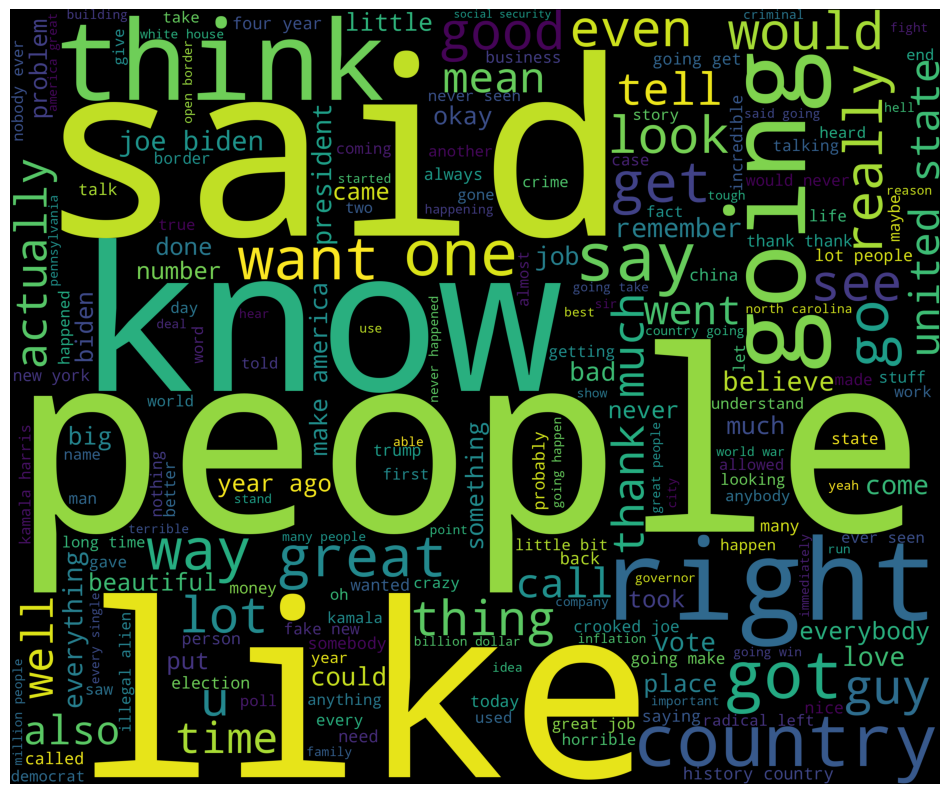

In [18]:
cleaned_word = ' '.join(df['cleaned_speech'])

wordcloud = WordCloud(stopwords=set(stopwords.words('english')),
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(cleaned_word)


plt.figure(1, figsize=(12, 12))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

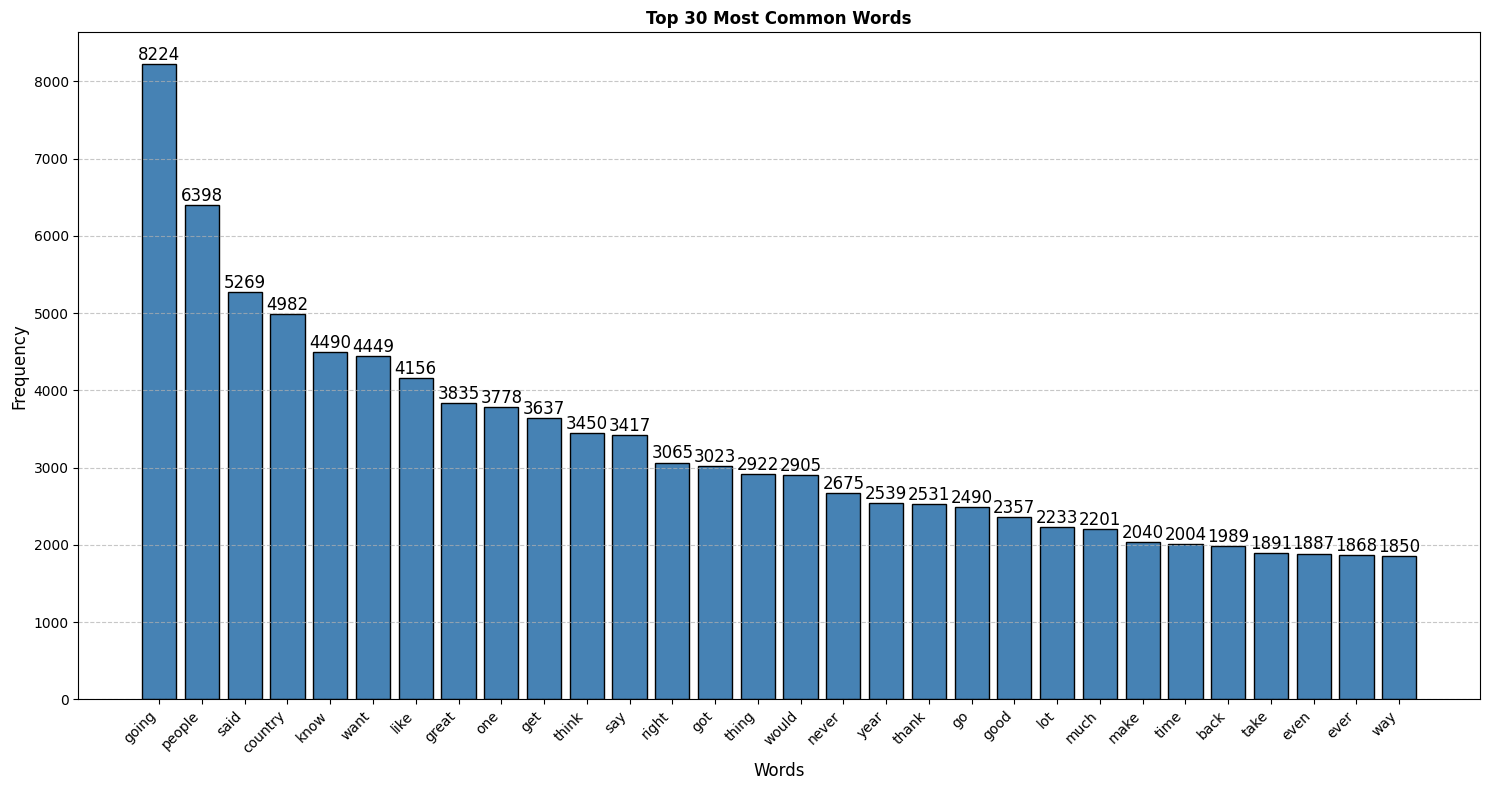

In [19]:
all_words = ' '.join(df['cleaned_speech']).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(30)

words = [word[0] for word in common_words]
counts = [word[1] for word in common_words]

plt.figure(figsize=(15, 8))
bars = plt.bar(words, counts, color='steelblue', edgecolor='black')

plt.title('Top 30 Most Common Words', fontsize=12, fontweight='bold')
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, int(yval), ha='center', va='bottom', fontsize=12)

plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [20]:
# TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, max_features=5000, min_df=2, stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(df['cleaned_speech'])


In [21]:
tfidf_matrix

<99x5000 sparse matrix of type '<class 'numpy.float64'>'
	with 98377 stored elements in Compressed Sparse Row format>

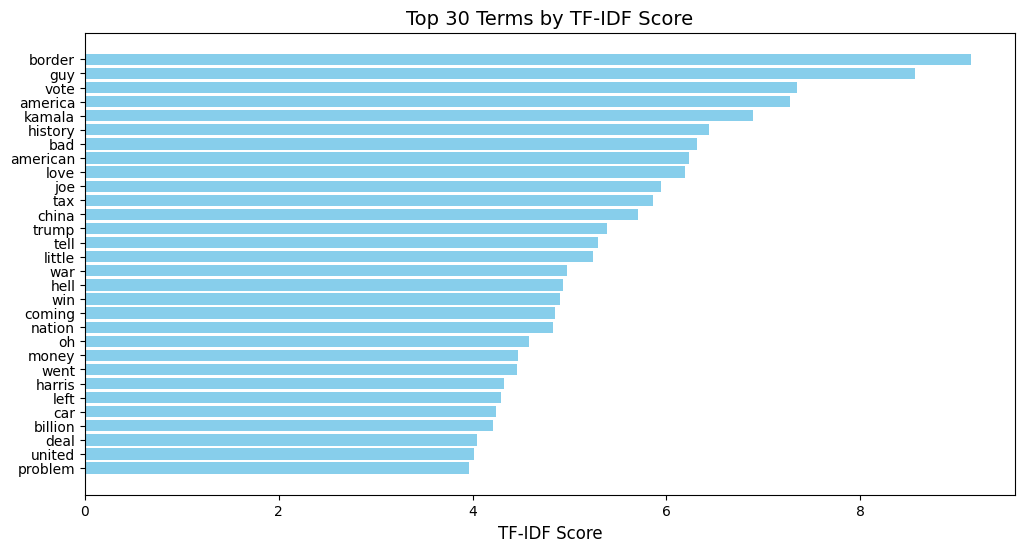

In [22]:
# Get feature names and TF-IDF scores
feature_names = tfidf_vectorizer.get_feature_names_out()
tfidf_scores = np.asarray(tfidf_matrix.sum(axis=0)).flatten()

# Get top 30 terms by TF-IDF score
top_indices = tfidf_scores.argsort()[-30:][::-1]
top_terms = [feature_names[i] for i in top_indices]
top_scores = tfidf_scores[top_indices]

# Plot top terms
plt.figure(figsize=(12, 6))
plt.barh(top_terms, top_scores, color='skyblue')
plt.title("Top 30 Terms by TF-IDF Score", fontsize=14)
plt.gca().invert_yaxis()
plt.xlabel("TF-IDF Score", fontsize=12)
plt.show()

In [23]:
# Latent Dirichlet Allocation (LDA) for topic modeling
numberOftopics = 15
lda = LatentDirichletAllocation(n_components = numberOftopics, random_state=42)
lda_matrix = lda.fit(tfidf_matrix)    

In [24]:
# print the top words for each topic
n_top_words = 20
words = tfidf_vectorizer.get_feature_names_out()
topic_keywords = {}

for topic_idx, topic in enumerate(lda.components_):
    topic_keywords[f"Topic {topic_idx}"] = [words[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
    print(f"Topic {topic_idx}: {' '.join(topic_keywords[f'Topic {topic_idx}'])}")
    print()

Topic 0: cage reprimanded crib gretchen affair riding treasure attend yale consistent barren devin ridden investigated underway beverly libertarian nunes lloyd recovering

Topic 1: frack starlink occupied muslim brian tren aragua communication forest imported underway brien possibility toss verge du deductibility smelt rated katrina

Topic 2: brian matt sam marjorie commonwealth test lieutenant rick dan laken huh henry religious brave tuesday church robert fani doug laura

Topic 3: joe nation woman crooked poll fake case wanted happening house law story record best republican far terrible point administration vote

Topic 4: reprimanded cage crib gretchen affair riding treasure attend yale consistent barren devin ridden investigated underway beverly libertarian nunes lloyd recovering

Topic 5: guy border kamala america history bad love tax china american tell little vote trump hell coming war oh money win

Topic 6: fixer conflicted plea ridden testify affair greg dog 77 rebuffed testimo

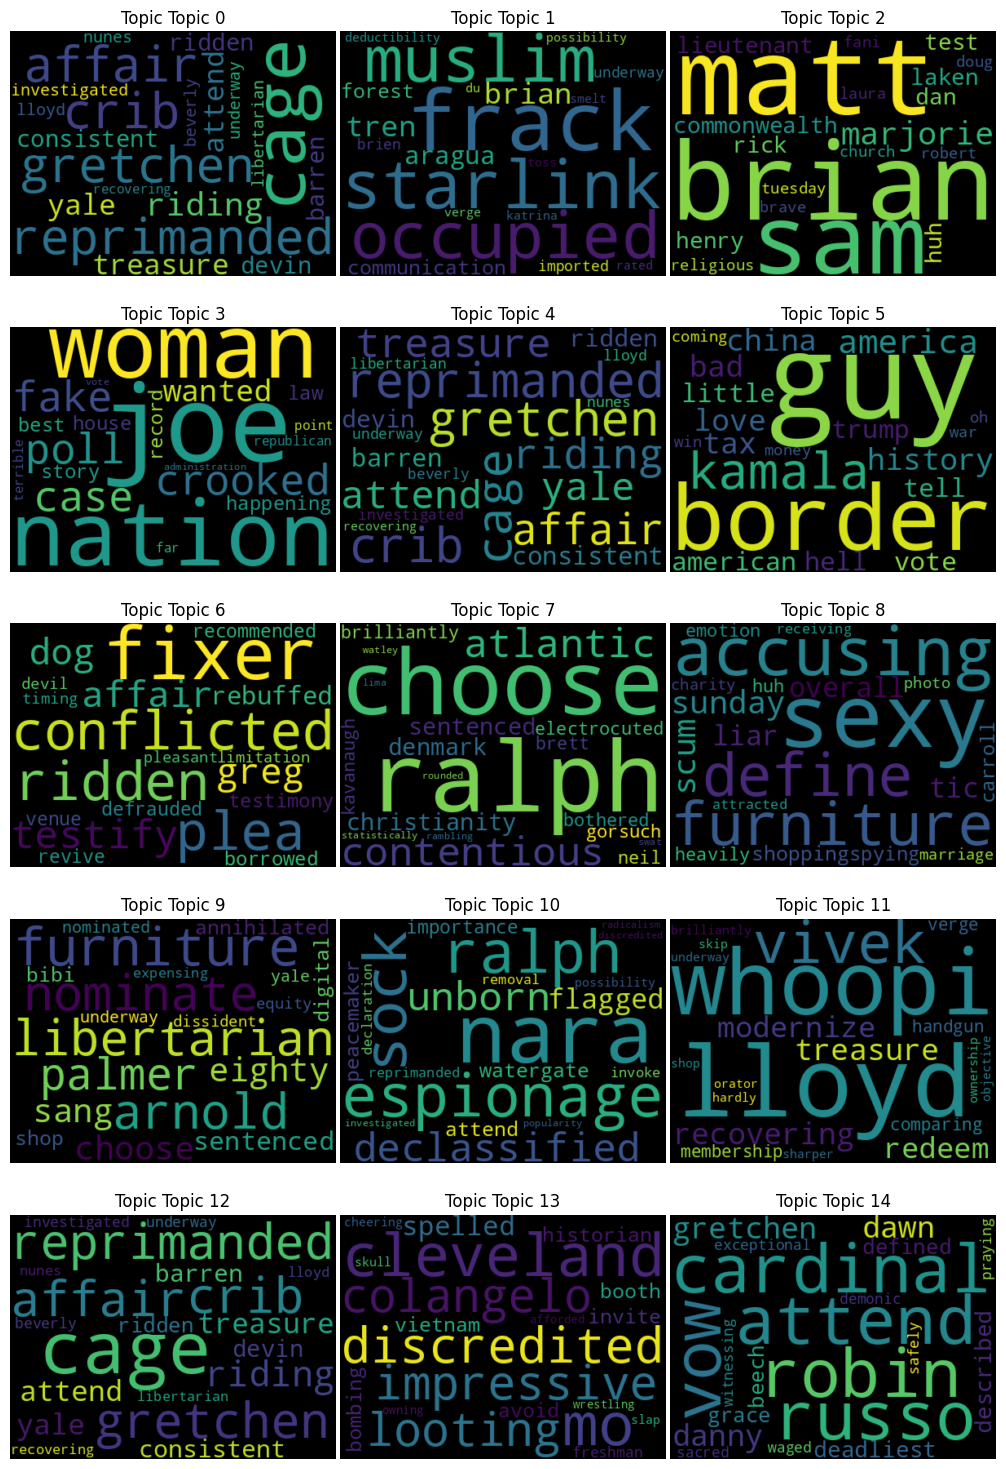

In [25]:
num_topics = len(topic_keywords)
fig, axes = plt.subplots(nrows=(num_topics // 3) + (num_topics % 3), ncols=3, figsize=(10, num_topics))
axes = axes.flatten()

for i, (topic, keywords) in enumerate(topic_keywords.items()):
    wordcloud = WordCloud(width=400, height=300, background_color='black').generate(" ".join(keywords))
    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(f"Topic {topic}")

# remove any empty subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout(pad=0.5, w_pad=0.3, h_pad=0.5)
plt.show()


In [26]:
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
# Create a BERTopic model with the custom embeddings
bert_model = BERTopic(
    embedding_model = embedding_model,
    verbose = True,
    min_topic_size = 3,
    # nr_topics=10,
    language = "english",
)

# Fit the model on your data
topics, probs = bert_model.fit_transform(df['cleaned_speech'])

2025-01-11 17:49:21,917 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/4 [00:00<?, ?it/s]

2025-01-11 17:49:22,849 - BERTopic - Embedding - Completed ✓
2025-01-11 17:49:22,849 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-01-11 17:49:25,714 - BERTopic - Dimensionality - Completed ✓
2025-01-11 17:49:25,715 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-01-11 17:49:25,722 - BERTopic - Cluster - Completed ✓
2025-01-11 17:49:25,724 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-01-11 17:49:25,886 - BERTopic - Representation - Completed ✓


In [27]:
# check topic information
topic_info = bert_model.get_topic_info()
topic_info

Topic  Count                          Name  \
0     -1     15  -1_going_people_country_said   
1      0     28   0_people_going_know_country   
2      1     26   1_going_people_said_country   
3      2     15   2_going_said_people_country   
4      3     10   3_going_people_said_country   
5      4      5  4_going_country_great_people   

                                      Representation  \
0  [going, people, country, said, want, know, lik...   
1  [people, going, know, country, said, want, thi...   
2  [going, people, said, country, like, want, kno...   
3  [going, said, people, country, know, want, thi...   
4  [going, people, said, country, want, one, grea...   
5  [going, country, great, people, know, one, lik...   

                                 Representative_Docs  
0  [big hello reno love reno hello nevada great b...  
1  [pledge allegiance flag united state america r...  
2  [well thank much like michigan football game p...  
3  [first came office cut tax president created s...  
4  [wow thank thank everybody thank much well tha...  
5  [first came office cut tax president created s...

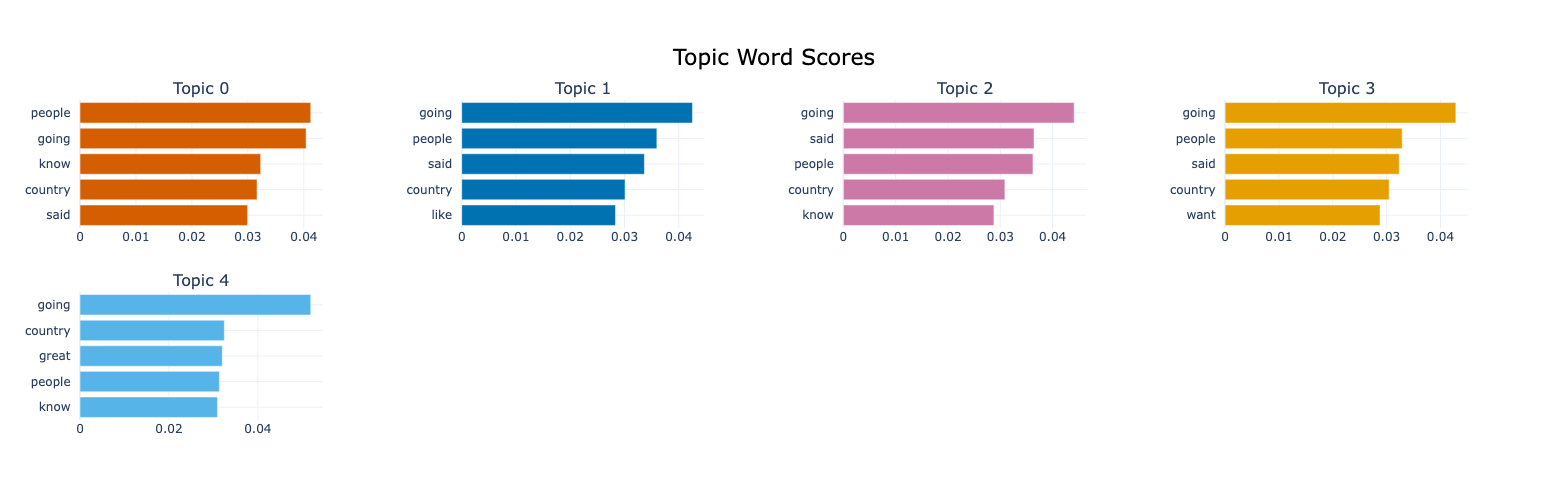

In [28]:
bert_model.visualize_barchart()

29it [00:00, 100.99it/s]


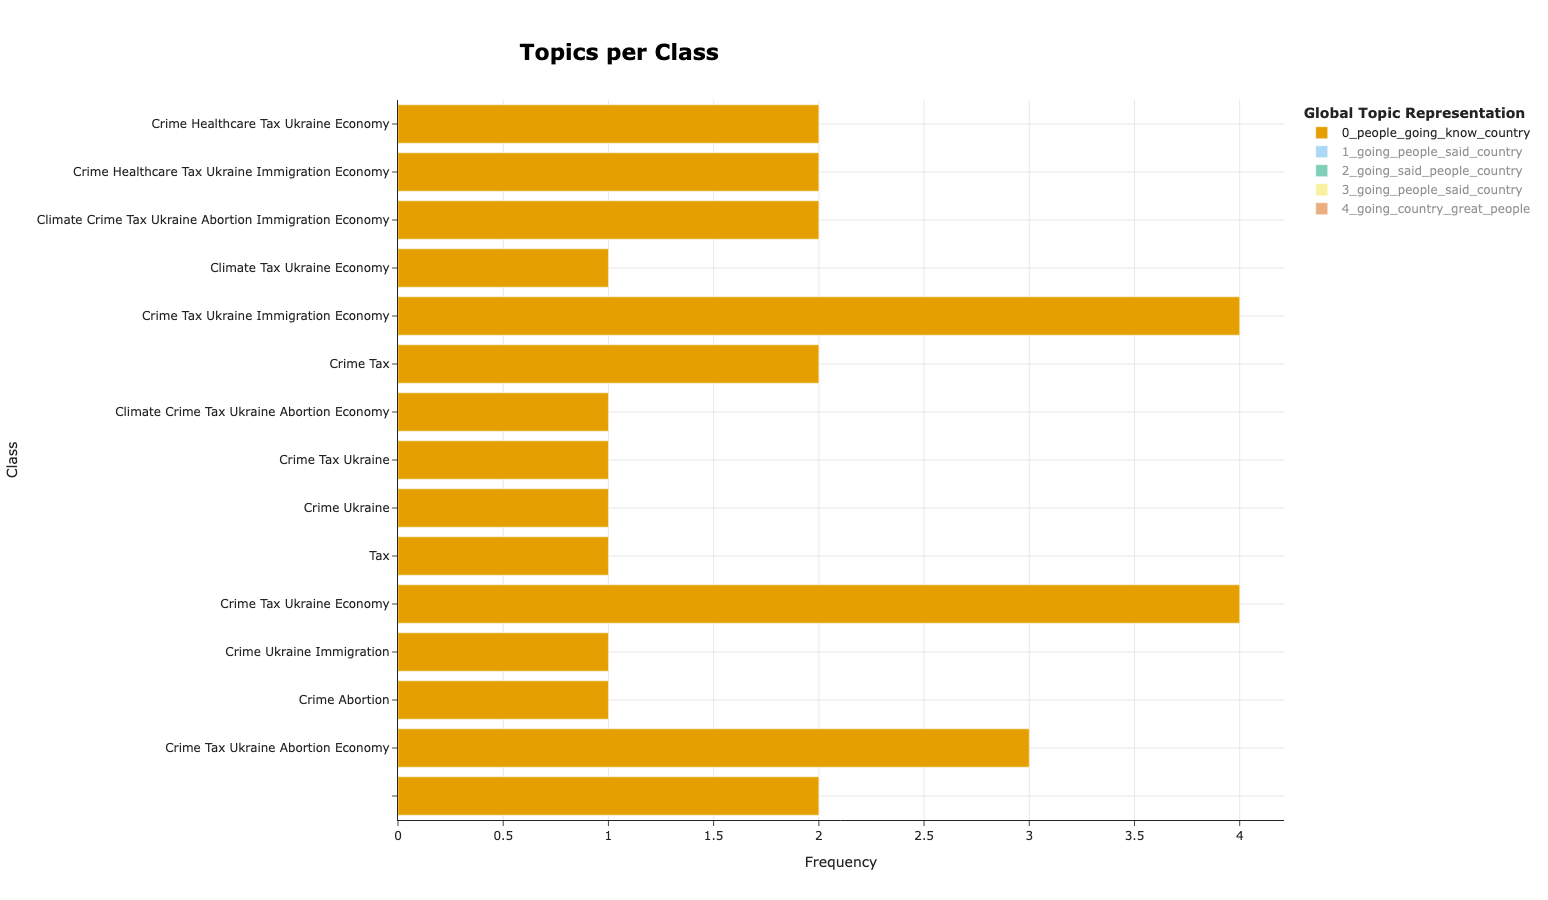

In [29]:
topics_per_class = bert_model.topics_per_class(docs=df['cleaned_speech'], classes=df['class_labels'])
bert_model.visualize_topics_per_class(topics_per_class, top_n_topics=20)

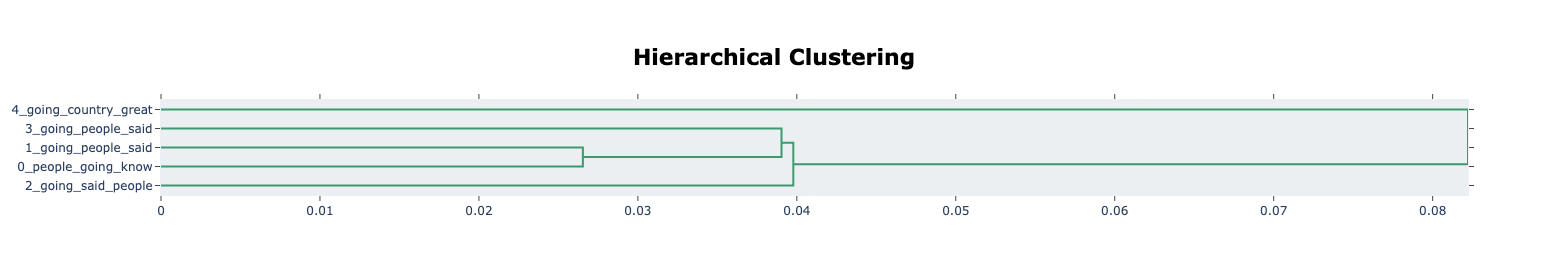

In [30]:
bert_model.visualize_hierarchy()

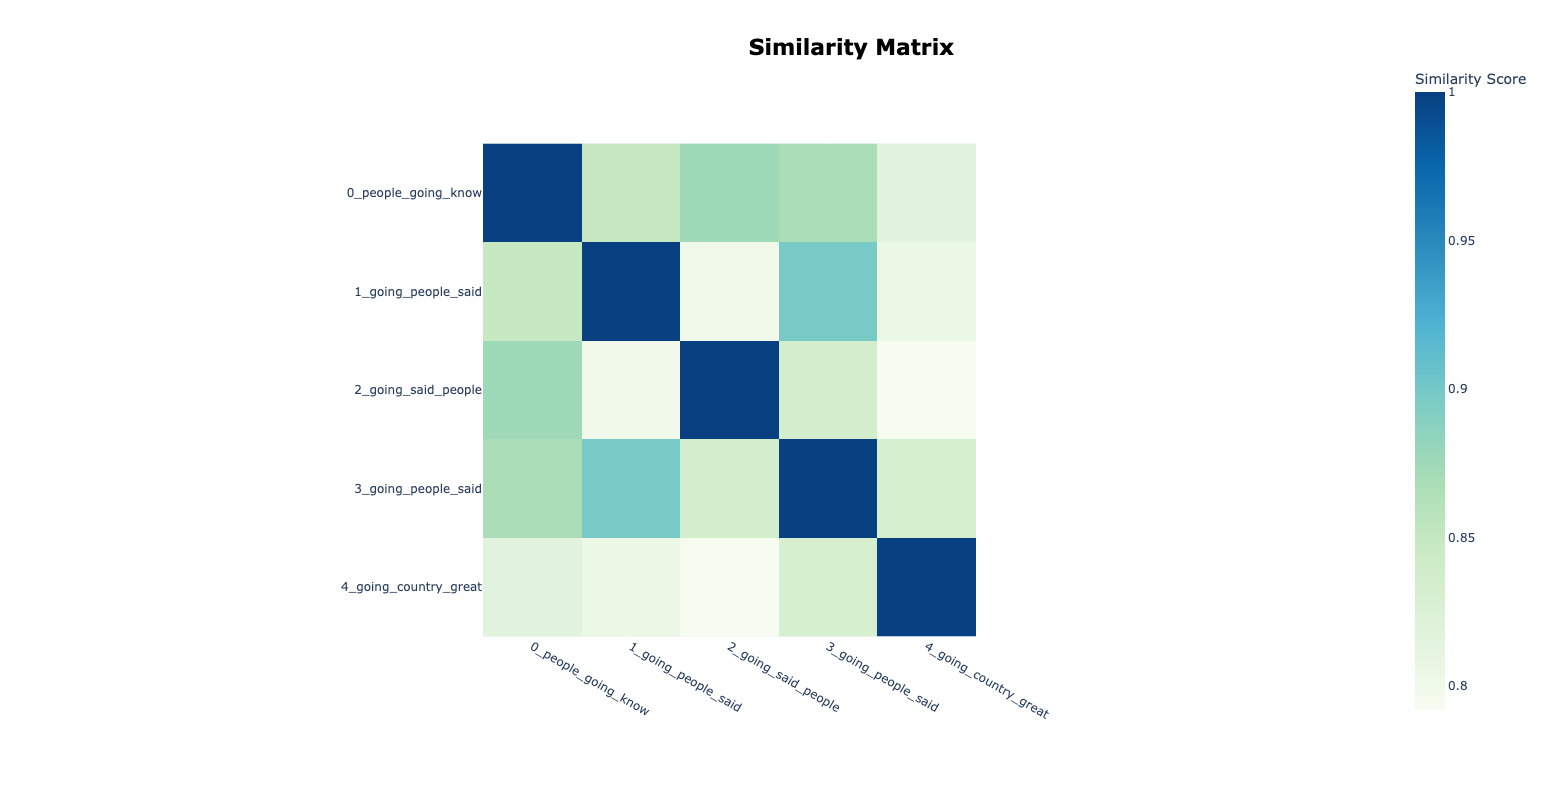

In [31]:
bert_model.visualize_heatmap()

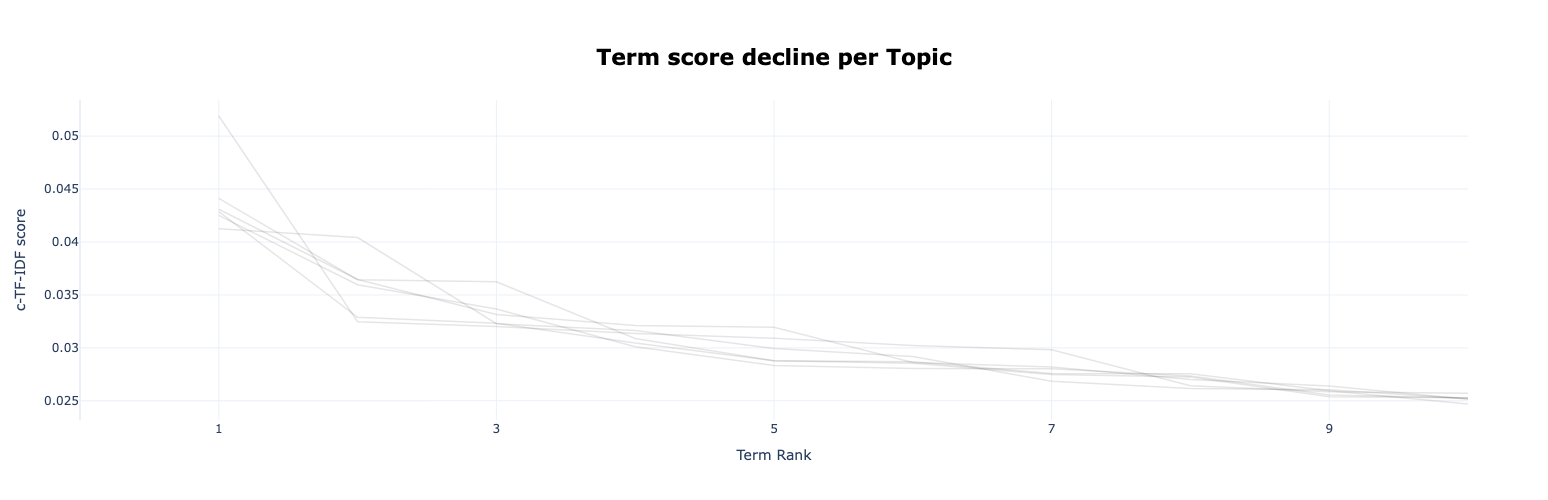

In [32]:
bert_model.visualize_term_rank()

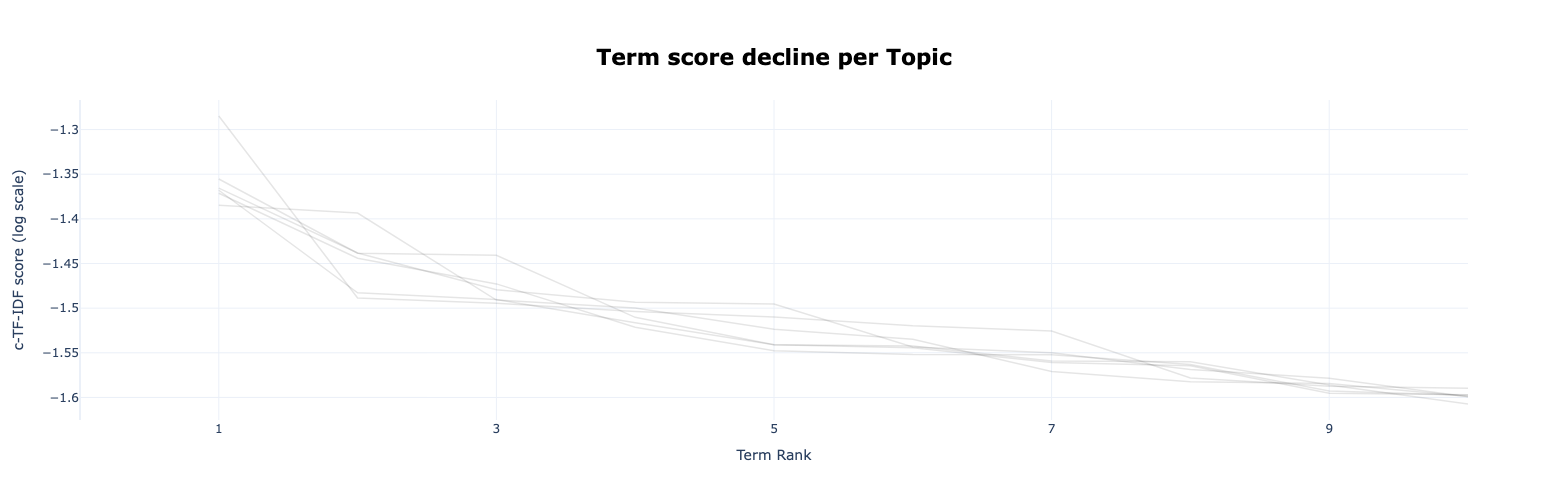

In [33]:
bert_model.visualize_term_rank(log_scale=True)

In [34]:
topics_over_time = bert_model.topics_over_time(df['cleaned_speech'], df['date'])

76it [00:00, 117.83it/s]


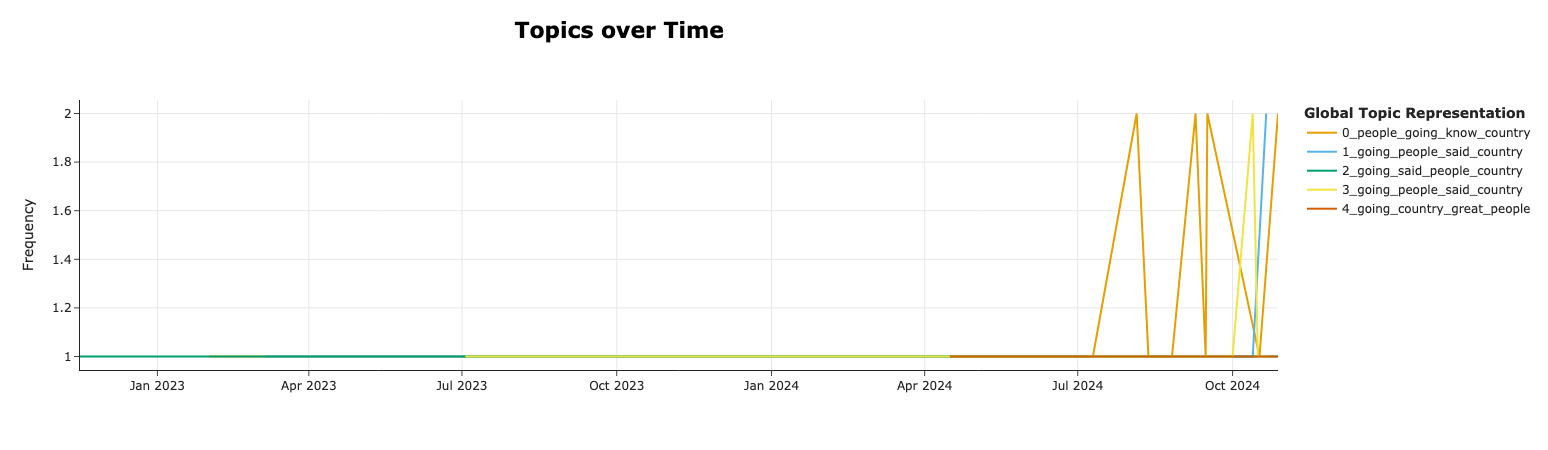

In [35]:
bert_model.visualize_topics_over_time(topics_over_time)

In [49]:
# Load pre-trained sentiment analysis pipeline
sentiment_pipeline = pipeline("sentiment-analysis", model="nlptown/bert-base-multilingual-uncased-sentiment", truncation=True, padding=True, max_length=512, device=0)

In [51]:
# RuntimeError: The size of tensor a (6086) must match the size of tensor b (512) at non-singleton dimension 1
# To use all the text of each speech we need to use chunking mechanism as the pre-trained model has token limitation.

# Load the tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("nlptown/bert-base-multilingual-uncased-sentiment")

# Function to split the text into chunks of max_length tokens
def split_into_chunks(text, max_length=510):
    # Tokenize the text
    tokens = bert_tokenizer.encode(text, add_special_tokens=True)

    # Adjust to ensure the tokens do not exceed the max_length (512 tokens - 2 special tokens for [CLS] and [SEP])
    max_length = min(max_length, 510 - 2)  # 512 tokens is the max for BERT, subtract space for special tokens
    
    # Split tokens into chunks of size max_length
    chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]
    return chunks
    
    # # Split tokens into chunks of size max_length
    # chunks = [tokens[i:i + max_length] for i in range(0, len(tokens), max_length)]
    # return chunks

# Function to convert sentiment label to a numerical value
def sentiment_label_to_int(label):
    # Define a mapping from sentiment label to integer values
    sentiment_map = {
        '1 star': 1,
        '2 stars': 2,
        '3 stars': 3,
        '4 stars': 4,
        '5 stars': 5
    }
    return sentiment_map.get(label, 0)  # Default to 0 if label is unknown


In [52]:
# Split the text into chunks
chunks = split_into_chunks(df['cleaned_speech'].iloc[0])

Token indices sequence length is longer than the specified maximum sequence length for this model (6090 > 512). Running this sequence through the model will result in indexing errors


In [54]:
df['bert_tokens'] = df['cleaned_speech'].apply(split_into_chunks)
df['token_length'] = df['bert_tokens'].apply(lambda x: sum(len(sublist) for sublist in x))

In [55]:
df.head()

date                                        location  \
0  2022-11-07                                    Pa For Dr Oz   
1  2022-11-16                                         Unknown   
2  2023-02-01  New York Attorney Generals Fraud Investigation   
3  2023-03-06                                            Cpac   
4  2023-03-14                                  Davenport Iowa   

                                              speech  \
0  \nYou’re going to elect Dr. Mehmet Oz to the U...   
1  \nWell, thank you very much, and on behalf of ...   
2  \nI do.\n\n\nGood morning.\n\n\nSure.\n\n\nYes...   
3  \nWell, thank you very much and I’m thrilled t...   
4  \nOh, thank you very much. Thank you very much...   

                                           file_path  \
0  data/text/trump-rally-in-pa-for-dr-oz-11-05-22...   
1  data/text/former-president-trump-announces-202...   
2  data/text/excerpts-of-donald-trumps-deposition...   
3  data/text/trump-speaks-at-cpac-2023-transcript...   
4  data/text/donald-trump-speech-in-davenport-iow...   

                                      cleaned_speech  \
0  going elect mehmet oz united state senate goin...   
1  well thank much behalf melania entire family w...   
2  good morning sure yes yes sure thanks think kn...   
3  well thank much thrilled back cpac thousand gr...   
4  oh thank much thank much thank great governor ...   

                       covered_campaign_topics  \
0   [Crime, Healthcare, Tax, Ukraine, Economy]   
1               [Crime, Tax, Ukraine, Economy]   
2                                        [Tax]   
3  [Crime, Tax, Ukraine, Immigration, Economy]   
4                        [Crime, Tax, Economy]   

                            class_labels  \
0   Crime Healthcare Tax Ukraine Economy   
1              Crime Tax Ukraine Economy   
2                                    Tax   
3  Crime Tax Ukraine Immigration Economy   
4                      Crime Tax Economy   

                                         bert_tokens  token_length  
0  [[101, 17010, 91761, 43621, 17704, 10681, 1065...          6090  
1  [[101, 11327, 67715, 12977, 48909, 29842, 1125...          4455  
2  [[101, 12050, 17577, 26210, 31617, 31617, 2621...           637  
3  [[101, 11327, 67715, 12977, 29263, 55586, 1039...          7553  
4  [[101, 17003, 67715, 12977, 67715, 12977, 6771...          5309

## BERT Token distributiom

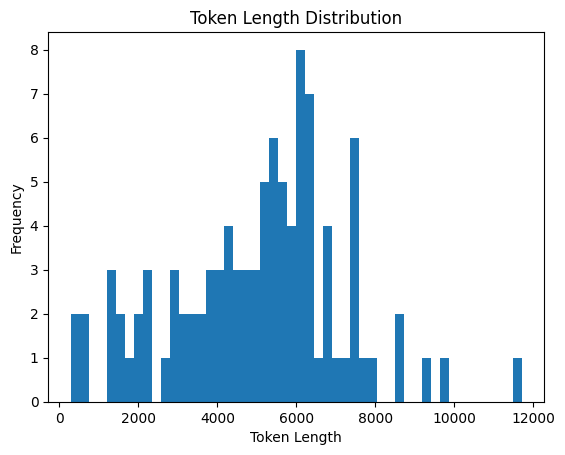

In [56]:
# Visualize token lengths
plt.hist(df['token_length'], bins=50)
plt.title('Token Length Distribution')
plt.xlabel('Token Length')
plt.ylabel('Frequency')
plt.show()

In [57]:
# Process each chunk and get sentiment results
def get_aggregate_sentiment(text):
    chunks = split_into_chunks(text)
    sentiment_results = []
    for chunk in chunks:
        # Decode the tokens back to text
        chunk_text = bert_tokenizer.decode(chunk, skip_special_tokens=True)
        # Get sentiment prediction for the chunk
        sentiment = sentiment_pipeline(chunk_text)
        # print(sentiment)
        sentiment_label = sentiment[0]['label']
        sentiment_results.append(sentiment_label_to_int(sentiment_label))
    
    # Aggregate the results (e.g., taking the most common sentiment)
    # We are considering here the most frequent sentiment
    # agg_sentiment = np.mean(sentiment_results)
    # For further exploration we could also average the sentiment score if using a model that provides scores
    agg_sentiment = np.bincount(sentiment_results).argmax()
    return agg_sentiment

print(f"Aggregated Sentiment: {get_aggregate_sentiment(df['cleaned_speech'].iloc[0])}")

Aggregated Sentiment: 1


In [60]:
df['campaign_topics_sentiment'] = df['cleaned_speech'].apply(get_aggregate_sentiment)

In [61]:
df.head()

date                                        location  \
0  2022-11-07                                    Pa For Dr Oz   
1  2022-11-16                                         Unknown   
2  2023-02-01  New York Attorney Generals Fraud Investigation   
3  2023-03-06                                            Cpac   
4  2023-03-14                                  Davenport Iowa   

                                              speech  \
0  \nYou’re going to elect Dr. Mehmet Oz to the U...   
1  \nWell, thank you very much, and on behalf of ...   
2  \nI do.\n\n\nGood morning.\n\n\nSure.\n\n\nYes...   
3  \nWell, thank you very much and I’m thrilled t...   
4  \nOh, thank you very much. Thank you very much...   

                                           file_path  \
0  data/text/trump-rally-in-pa-for-dr-oz-11-05-22...   
1  data/text/former-president-trump-announces-202...   
2  data/text/excerpts-of-donald-trumps-deposition...   
3  data/text/trump-speaks-at-cpac-2023-transcript...   
4  data/text/donald-trump-speech-in-davenport-iow...   

                                      cleaned_speech  \
0  going elect mehmet oz united state senate goin...   
1  well thank much behalf melania entire family w...   
2  good morning sure yes yes sure thanks think kn...   
3  well thank much thrilled back cpac thousand gr...   
4  oh thank much thank much thank great governor ...   

                       covered_campaign_topics  \
0   [Crime, Healthcare, Tax, Ukraine, Economy]   
1               [Crime, Tax, Ukraine, Economy]   
2                                        [Tax]   
3  [Crime, Tax, Ukraine, Immigration, Economy]   
4                        [Crime, Tax, Economy]   

                            class_labels  \
0   Crime Healthcare Tax Ukraine Economy   
1              Crime Tax Ukraine Economy   
2                                    Tax   
3  Crime Tax Ukraine Immigration Economy   
4                      Crime Tax Economy   

                                         bert_tokens  token_length  \
0  [[101, 17010, 91761, 43621, 17704, 10681, 1065...          6090   
1  [[101, 11327, 67715, 12977, 48909, 29842, 1125...          4455   
2  [[101, 12050, 17577, 26210, 31617, 31617, 2621...           637   
3  [[101, 11327, 67715, 12977, 29263, 55586, 1039...          7553   
4  [[101, 17003, 67715, 12977, 67715, 12977, 6771...          5309   

   campaign_topics_sentiment  
0                          1  
1                          1  
2                          1  
3                          1  
4                          1

## Sentiment Analysis Based on BERT

In [77]:
def classify_sentiment_based_on_score(score, threshold=0.6):
    if score >= threshold:  # Positive sentiment if score is above threshold
        return 'positive'
    elif score <= (1 - threshold):  # Negative sentiment if score is below threshold
        return 'negative'
    else:  # Neutral if the score is in between
        return 'neutral'

In [80]:
# df['sentiment'] = df['cleaned_speech'].apply(lambda x: sentiment_pipeline(x)[0]['label'])

In [81]:
df['sentiment_score'] = df['cleaned_speech'].apply(lambda x: sentiment_pipeline(x)[0]['score'])

In [82]:
df['sentiment'] = df['sentiment_score'].apply(classify_sentiment_based_on_score)

In [83]:
df.head()

date                                        location  \
0 2022-11-07                                    Pa For Dr Oz   
1 2022-11-16                                         Unknown   
2 2023-02-01  New York Attorney Generals Fraud Investigation   
3 2023-03-06                                            Cpac   
4 2023-03-14                                  Davenport Iowa   

                                              speech  \
0  \nYou’re going to elect Dr. Mehmet Oz to the U...   
1  \nWell, thank you very much, and on behalf of ...   
2  \nI do.\n\n\nGood morning.\n\n\nSure.\n\n\nYes...   
3  \nWell, thank you very much and I’m thrilled t...   
4  \nOh, thank you very much. Thank you very much...   

                                           file_path  \
0  data/text/trump-rally-in-pa-for-dr-oz-11-05-22...   
1  data/text/former-president-trump-announces-202...   
2  data/text/excerpts-of-donald-trumps-deposition...   
3  data/text/trump-speaks-at-cpac-2023-transcript...   
4  data/text/donald-trump-speech-in-davenport-iow...   

                                      cleaned_speech  \
0  going elect mehmet oz united state senate goin...   
1  well thank much behalf melania entire family w...   
2  good morning sure yes yes sure thanks think kn...   
3  well thank much thrilled back cpac thousand gr...   
4  oh thank much thank much thank great governor ...   

                       covered_campaign_topics  \
0   [Crime, Healthcare, Tax, Ukraine, Economy]   
1               [Crime, Tax, Ukraine, Economy]   
2                                        [Tax]   
3  [Crime, Tax, Ukraine, Immigration, Economy]   
4                        [Crime, Tax, Economy]   

                            class_labels  \
0   Crime Healthcare Tax Ukraine Economy   
1              Crime Tax Ukraine Economy   
2                                    Tax   
3  Crime Tax Ukraine Immigration Economy   
4                      Crime Tax Economy   

                                         bert_tokens  token_length  \
0  [[101, 17010, 91761, 43621, 17704, 10681, 1065...          6090   
1  [[101, 11327, 67715, 12977, 48909, 29842, 1125...          4455   
2  [[101, 12050, 17577, 26210, 31617, 31617, 2621...           637   
3  [[101, 11327, 67715, 12977, 29263, 55586, 1039...          7553   
4  [[101, 17003, 67715, 12977, 67715, 12977, 6771...          5309   

   campaign_topics_sentiment sentiment  sentiment_score score2sentiment  
0                          1  positive         0.680090        positive  
1                          1   neutral         0.494940         neutral  
2                          1  positive         0.792272        positive  
3                          1  negative         0.378734        negative  
4                          1  negative         0.388847        negative

In [84]:
df['sentiment'].value_counts()

sentiment
positive    63
neutral     28
negative     8
Name: count, dtype: int64

## Sentiment distribution

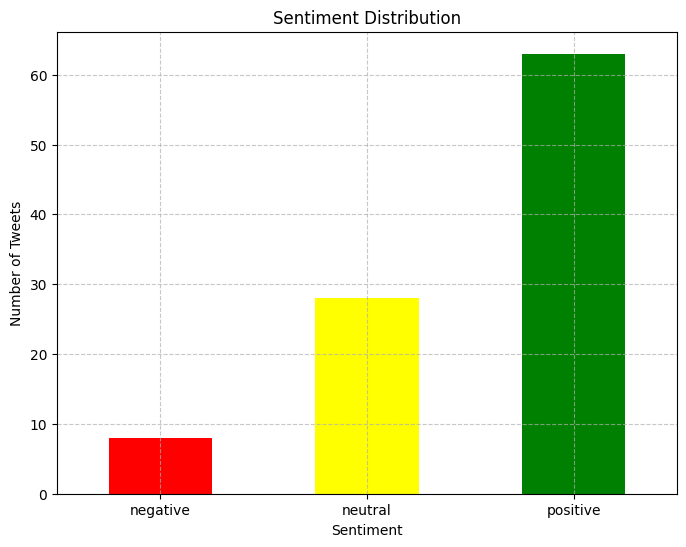

In [87]:
plt.figure(figsize=(8, 6))
df.groupby('sentiment').size().plot(kind='bar', color=['red', 'yellow', 'green'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Sentiment Over Time

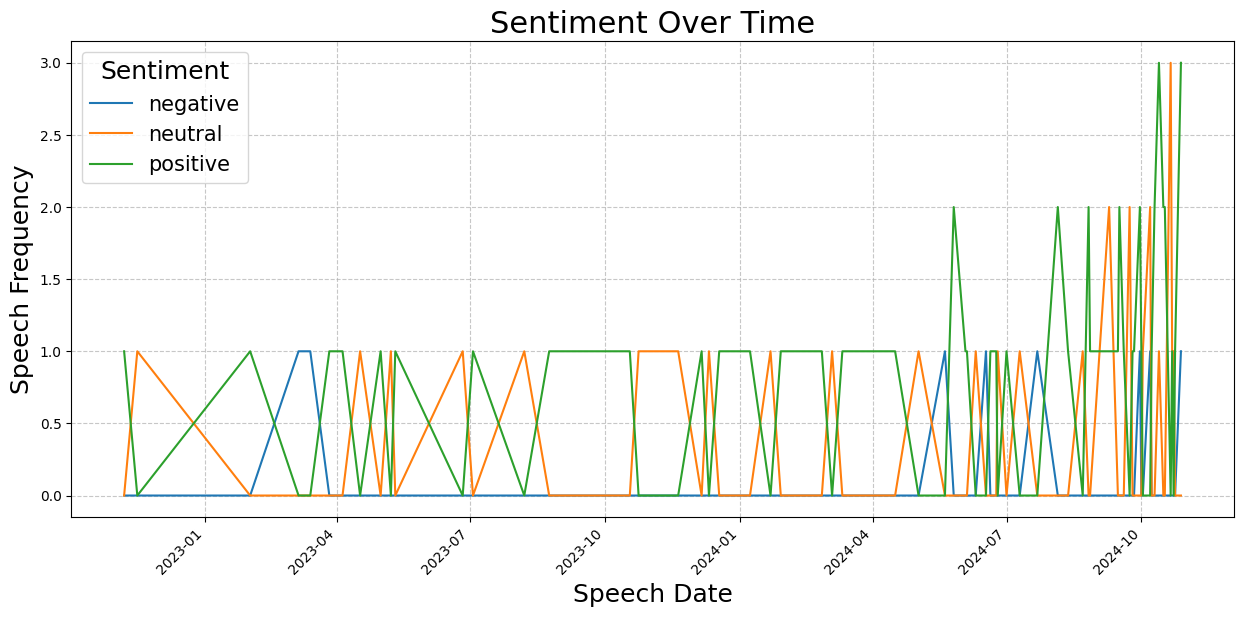

In [89]:
# Group by tweet_created_date and airline_sentiment
sentiment_over_time = df.groupby(['date', 'sentiment']).size().unstack().fillna(0)

# Plot the sentiment over time
sentiment_over_time.plot(kind='line', figsize=(15, 7))
plt.title('Sentiment Over Time', fontsize=22)
plt.xlabel('Speech Date', fontsize=18)
plt.ylabel('Speech Frequency', fontsize=18)
plt.xticks(rotation=45)
plt.legend(title='Sentiment', fontsize=15, title_fontsize=18)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

## Positive wordcloud

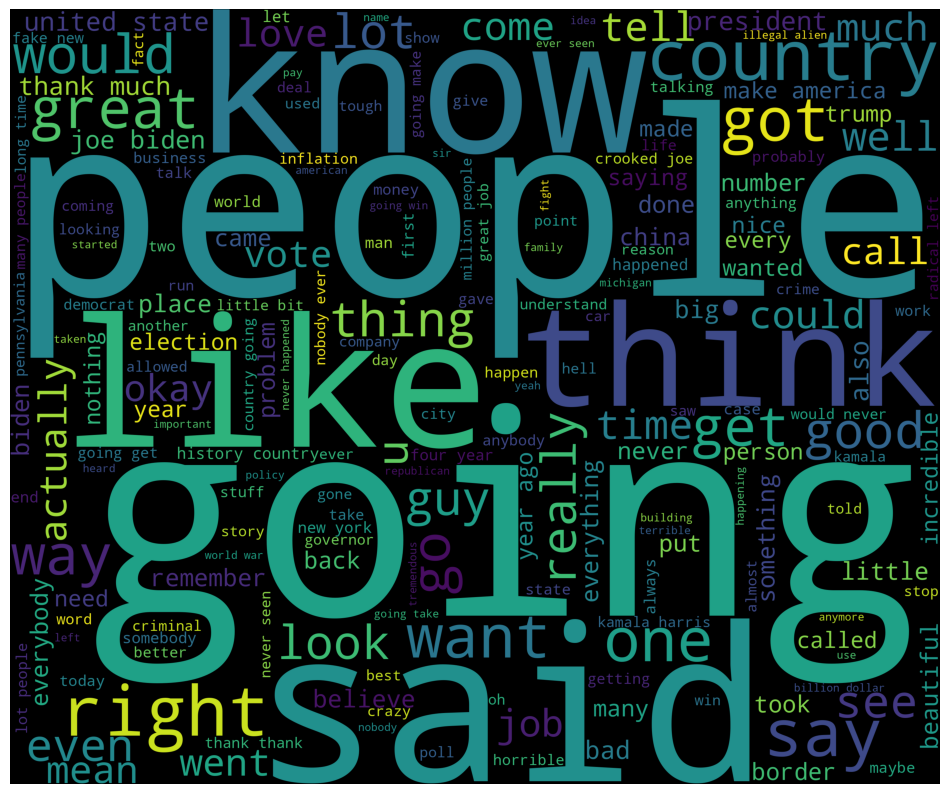

In [90]:
pos_df = df[df['sentiment']=='positive']

pos_cleaned_word = ' '.join(pos_df['cleaned_speech'])

pos_wordcloud = WordCloud(stopwords=set(stop_words),
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(pos_cleaned_word)


plt.figure(1, figsize=(12, 12))
plt.imshow(pos_wordcloud)
plt.axis('off')
plt.show()

## Negative wordcloud

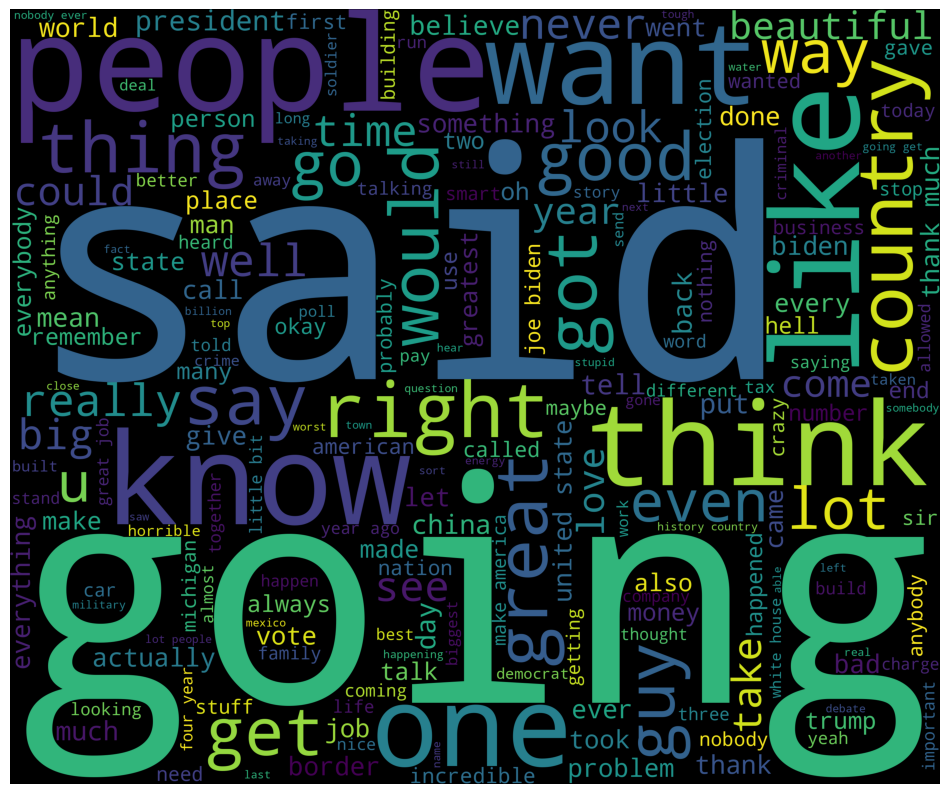

In [91]:
neg_df = df[df['sentiment']=='negative']

neg_cleaned_word = ' '.join(neg_df['cleaned_speech'])

neg_wordcloud = WordCloud(stopwords=set(stop_words),
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(neg_cleaned_word)


plt.figure(1, figsize=(12, 12))
plt.imshow(neg_wordcloud)
plt.axis('off')
plt.show()

## Neutral wordcloud

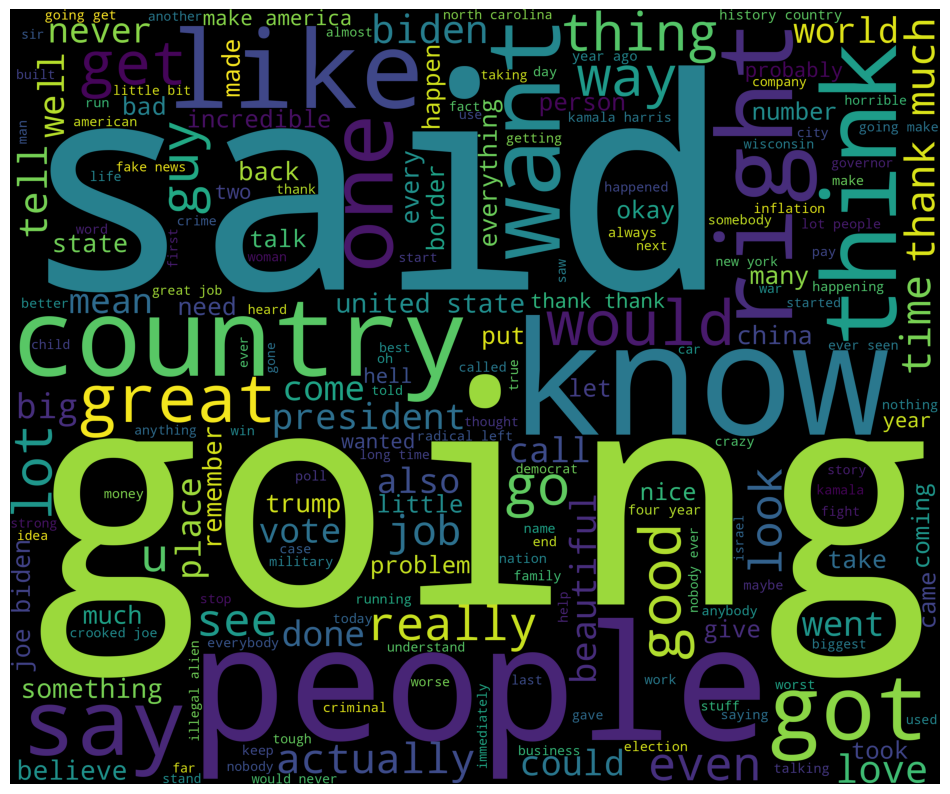

In [92]:
neut_df = df[df['sentiment']=='neutral']

neut_cleaned_word = ' '.join(neut_df['cleaned_speech'])

neut_wordcloud = WordCloud(stopwords=set(stop_words),
                      background_color='black',
                      width=3000,
                      height=2500
                     ).generate(neut_cleaned_word)


plt.figure(1, figsize=(12, 12))
plt.imshow(neut_wordcloud)
plt.axis('off')
plt.show()